# Gaussian Process for Event likelihoods

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions

## Creating some random data

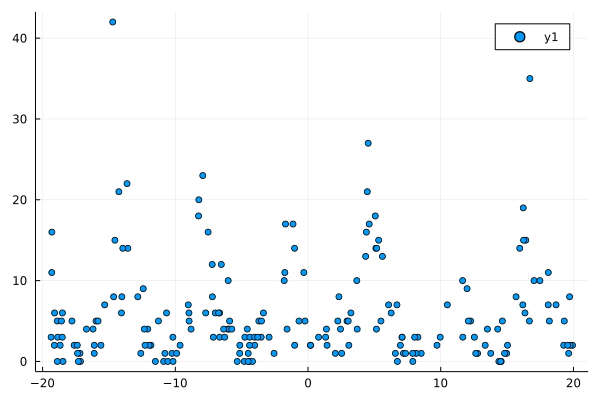

In [2]:
n_data = 200
X = (rand(n_data) .- 0.5) * 40
r = 5.0
Y = rand.(NegativeBinomial.(r, AGP.logistic.(sin.(X))))
scatter(X, Y)

## Run GP model with negative binomial likelihood to learn p

In [3]:
kernel = SqExponentialKernel() ∘ ScaleTransform(1.0)
m_negbinomial = VGP(
    X, Y, kernel, NegBinomialLikelihood(r), AnalyticVI(); optimiser=false, verbose=2
)
@time train!(m_negbinomial, 20)

[ Info: Starting training Variational Gaussian Process with a Negative Binomial Likelihood (r = 5.0) infered by Analytic Variational Inference  with 200 samples, 1 features and 1 latent GP
Training Progress: 100%|████████████████████████████████| Time: 0:00:02
  iter:  20
  ELBO:  -535.7217056887016
[ Info: Training ended after 20 iterations. Total number of iterations 20
  3.056910 seconds (6.19 M allocations: 409.173 MiB, 2.31% gc time, 97.49% compilation time)


(Variational Gaussian Process with a Negative Binomial Likelihood (r = 5.0) infered by Analytic Variational Inference , (local_vars = (c = [0.5148513304284049, 0.41157455731807974, 0.6043259024926019, 0.5831325092791634, 0.3031845295868936, 0.2798767433333627, 0.5652631074485905, 0.37417733213918847, 0.18076701791818303, 0.5450335619729652  …  0.2008467980805813, 0.2945095809183016, 0.28330618589525064, 0.4874776611400317, 0.5526616827917505, 0.24202332695482065, 0.5428400799775616, 0.18825307471944783, 0.28304946869957665, 0.30550484256511173], θ = [5.381644987582973, 2.9583568621288707, 2.426594312510904, 3.8903782714437565, 4.465843612012154, 3.974092585949073, 2.43549319297091, 4.942468409841303, 4.986429045875658, 2.439896970838649  …  5.481585371702973, 6.453422014464105, 3.4767765142654086, 9.806566621782869, 2.9259036086138956, 5.970882896996958, 3.416512337617846, 5.483814382249886, 3.9735065699478778, 7.4422060936813725]), opt_state = (NamedTuple(),), hyperopt_state = (NamedT

## Running the same model but with a Poisson likelihood

In [4]:
kernel = SqExponentialKernel() ∘ ScaleTransform(1.0)
m_poisson = VGP(
    X, Y, kernel, PoissonLikelihood(r), AnalyticVI(); optimiser=false, verbose=2
)
@time train!(m_poisson, 20)

[ Info: Starting training Variational Gaussian Process with a Poisson Likelihood (λ = 5.0) infered by Analytic Variational Inference  with 200 samples, 1 features and 1 latent GP
Training Progress: 100%|████████████████████████████████| Time: 0:00:01
  iter:  20
  ELBO:  -731.505247653932
[ Info: Training ended after 20 iterations. Total number of iterations 20
  2.265382 seconds (4.21 M allocations: 313.710 MiB, 2.50% gc time, 95.79% compilation time)


(Variational Gaussian Process with a Poisson Likelihood (λ = 13.249527336667734) infered by Analytic Variational Inference , (local_vars = (c = [0.5096696564206388, 0.5941753251983878, 0.778185872769921, 0.7674107080528045, 0.4822924251773371, 0.38977344695113875, 0.7447425405326097, 0.323545158071478, 0.3007032310726882, 0.7349130849938398  …  0.19186943991127883, 0.2237427396968198, 0.45563439505517267, 0.4721447728924631, 0.7418102429328576, 0.2437323280430803, 0.7211636174024482, 0.13758209061241292, 0.20422763340209626, 0.23001056560637628], θ = [5.387722194885154, 4.555866194502881, 4.277653581093103, 5.700418244756188, 5.923447091009476, 5.233378990547746, 4.249213957344526, 5.282319872880056, 6.187409935041542, 4.259311366501115  …  6.4030543016019985, 6.988114078285612, 4.907410987074549, 9.882587281932281, 4.723804394339659, 6.929400941044504, 5.190078707036618, 6.334081181688063, 4.634357546311673, 8.113742291304828], γ = [5.007696032302139, 8.378238630996865, 8.982750328039

Prediction and plot function on a grid
Create a grid and compute prediction on it

In [5]:
function compute_grid(model, n_grid=50)
    mins = -20
    maxs = 20
    x_grid = range(mins, maxs; length=n_grid) # Create a grid
    y_grid, sig_y_grid = proba_y(model, reshape(x_grid, :, 1)) # Predict the mean and variance on the grid
    return y_grid, sig_y_grid, x_grid
end

compute_grid (generic function with 2 methods)

Plot the data as a scatter plot

In [6]:
function plot_data(X, Y)
    return Plots.scatter(X, Y; alpha=0.33, msw=0.0, lab="", size=(800, 500))
end

function plot_model(model, X, Y, title=nothing)
    n_grid = 100
    y_grid, sig_y_grid, x_grid = compute_grid(model, n_grid)
    p = plot_data(X, Y)
    Plots.plot!(
        p,
        x_grid,
        y_grid;
        ribbon=2 * sqrt.(sig_y_grid), # Plot 2 std deviations
        title=title,
        color="red",
        lab="",
        linewidth=3.0,
    )
    return p
end;

## Comparison between the two likelihoods

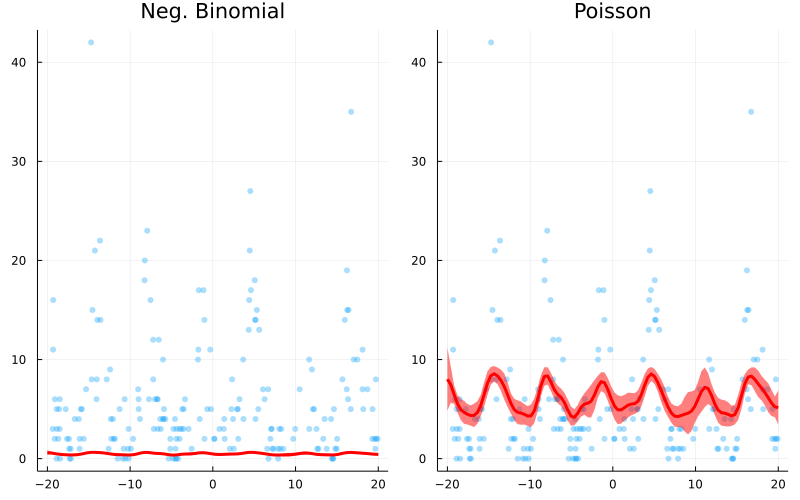

In [7]:
Plots.plot(
    plot_model.(
        [m_negbinomial, m_poisson], Ref(X), Ref(Y), ["Neg. Binomial", "Poisson"]
    )...;
    layout=(1, 2),
)

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*